In [88]:
import pandas as pd
import numpy as np
import re
import sklearn
#import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
#from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#import warnings
#warnings.filterwarnings('ignore')

In [89]:
# Load in the train and test datasets
trainC = pd.read_csv('train.csv')
testC = pd.read_csv('test.csv')

train = trainC
test = testC
combined = [train,test]
# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


See which features are catergorical, numerical, ordinal or mixed. 
Categorical:
Features are Embarked, Sex, Survived. Survived is the target feature. Ordinal is Pclass
Numerical:
Continuous features are Age and Fare. Discrete are SibSp and Parch. 
Ticket is mixed,Cabin is alphanumeric. 




In [90]:
train.info()
print('_'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

otal samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
Survived is a categorical feature with 0 or 1 values.
Around 38% samples survived representative of the actual survival rate at 32%.
Most passengers (> 75%) did not travel with parents or children.
Nearly 30% of the passengers had siblings and/or spouse aboard.
Fares varied significantly with few passengers (<1%) paying as high as $512.
Few elderly passengers (<1%) within age range 65-80.

In [91]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Names are unique across the dataset (count=unique=891)

Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
Cabin values have several duplicates across samples. Alternatively several passengers shared a cabin.
Embarked takes three possible values. S port used by most passengers (top=S)
Ticket feature has high ratio (22%) of duplicate values (unique=681).

In [92]:
#now checking which features are correlated
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [93]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [94]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [95]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


It is clear that sex and class are big contributors to survival. 

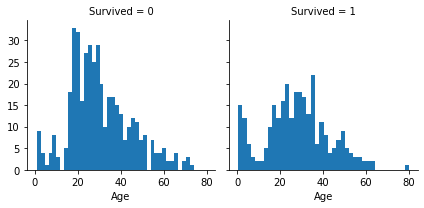

In [96]:
sn = sns.FacetGrid(train, col='Survived')
sn.map(plt.hist, 'Age', bins=40)

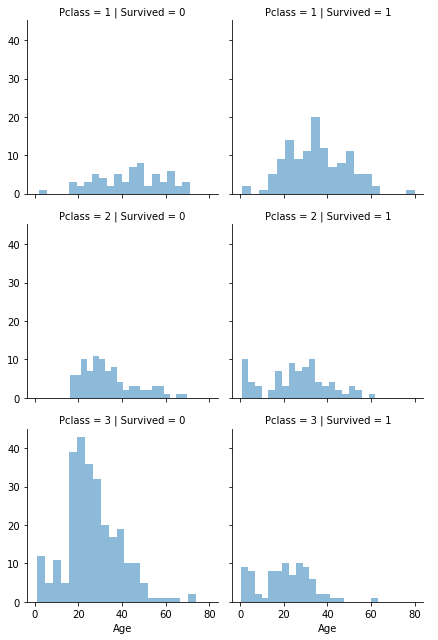

In [97]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

c:\Users\benpa\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.

c:\Users\benpa\anaconda3\lib\site-packages\seaborn\axisgrid.py:675: UserWarning:

Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.



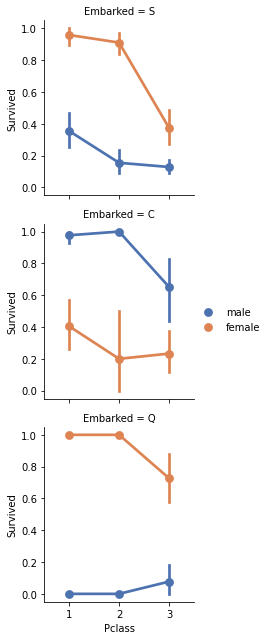

In [98]:
grid = sns.FacetGrid(train, row='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

c:\Users\benpa\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



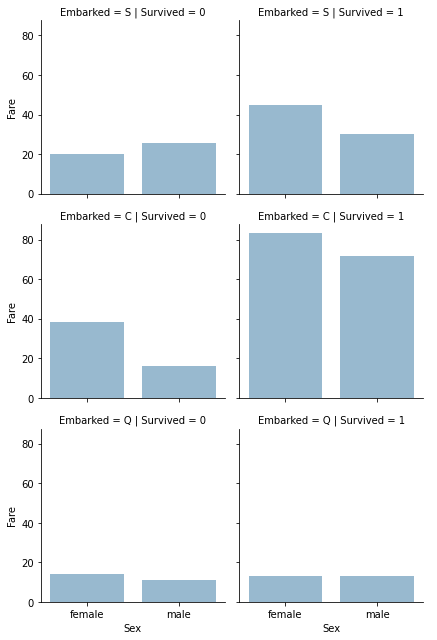

In [99]:
grid = sns.FacetGrid(train, row='Embarked', col='Survived')
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

What we can see from analysing the above data: Females, children under 10, Q embark and higher class passengers all had a higher chance of survival. 

In [100]:
#dropping Name, cabin, ticket,PassengerID
#each name is unique,tickets are unique except for some duplicates, cabin is missing a lot and duplicates, title wont tell you much more than sex. 

print("Before", train.shape, test.shape, combined[0].shape, combined[1].shape)

train = train.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'] ,axis=1)
test = test.drop(['Ticket', 'Cabin',  'Name'], axis=1)
combineNew = [train, test]

"After", train.shape, test.shape, combineNew[0].shape, combineNew[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 8), (418, 8), (891, 8), (418, 8))

In [101]:
#converting categorical into numerical
for dataset in combineNew:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S


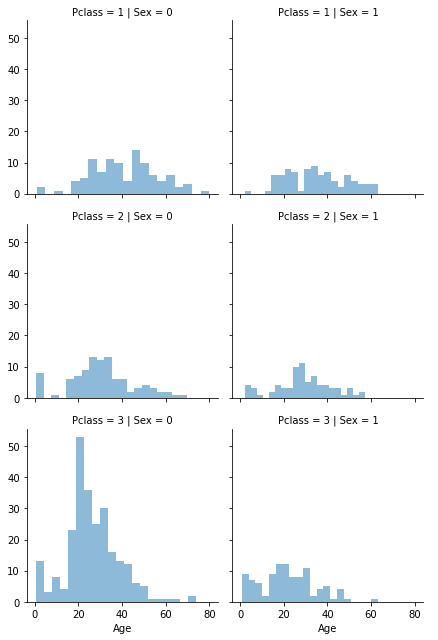

In [102]:
#Calculating missing Age values based on median values for Age across sets of PClass and# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train, row='Pclass', col='Sex')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend() 

In [103]:
guess_ages = np.zeros((2,3))
for dataset in combineNew:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train.head()
train.isna().sum()


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [104]:
train['AgeBand'] = pd.cut(train['Age'], 5)
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)
for dataset in combineNew:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
0,0,3,0,1,1,0,7.2500,S,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,"(32.0, 48.0]"


In [105]:
train = train.drop(['AgeBand'], axis=1)
combine = [train, test]
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,1,1,0,7.2500,S
1,1,1,1,2,1,0,71.2833,C
2,1,3,1,1,0,0,7.9250,S
3,1,1,1,2,1,0,53.1000,S
4,0,3,0,2,0,0,8.0500,S


In [106]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [107]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [108]:
train = train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train, test]

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,0,1,7.2500,S,0
1,1,1,1,2,71.2833,C,0
2,1,3,1,1,7.9250,S,1
3,1,1,1,2,53.1000,S,0
4,0,3,0,2,8.0500,S,1


In [109]:
freq_port = train.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [110]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,0,1,7.2500,0,0
1,1,1,1,2,71.2833,1,0
2,1,3,1,1,7.9250,0,1
3,1,1,1,2,53.1000,0,0
4,0,3,0,2,8.0500,0,1


In [111]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

In [112]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)
test.head()

train['FareBand'] = pd.qcut(train['Fare'], 4)
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [113]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train= train.drop(['FareBand'], axis=1)
combine = [train, test]
    
train.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Age*Class
0,0,3,0,1,0,0,0,3
1,1,1,1,2,3,1,0,2
2,1,3,1,1,1,0,1,3
3,1,1,1,2,3,0,0,2
4,0,3,0,2,1,0,1,6
5,0,3,0,1,1,2,1,3
6,0,1,0,3,3,0,1,3
7,0,3,0,0,2,0,0,0
8,1,3,1,1,1,0,0,3
9,1,2,1,0,2,1,0,0


In [114]:
test.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,IsAlone,Age*Class
0,892,3,0,2,0,2,1,6
1,893,3,1,2,0,0,0,6
2,894,2,0,3,1,2,1,6
3,895,3,0,1,1,0,1,3
4,896,3,1,1,1,0,0,3
5,897,3,0,0,1,0,1,0
6,898,3,1,1,0,2,1,3
7,899,2,0,1,2,0,0,2
8,900,3,1,1,0,1,1,3
9,901,3,0,1,2,0,0,3


Now that the datasets have been preprocesses, we can model and train. 

In [115]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [116]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

79.24

In [117]:
coeff_df = pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.482353
2,Age,0.310354
4,Embarked,0.259924
3,Fare,-0.052987
5,IsAlone,-0.070507
6,Age*Class,-0.332453
0,Pclass,-0.708059


In [119]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

68.01

In [120]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

60.27

In [121]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

78.0

In [123]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

83.73

In [124]:
models = pd.DataFrame({
    'Model': [ 'KNN', 'Logistic Regression', 
               'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent'],
    'Score': [ acc_knn, acc_log, 
               acc_gaussian, acc_perceptron, 
              acc_sgd]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,KNN,83.73
1,Logistic Regression,79.24
4,Stochastic Gradient Decent,78.00
2,Naive Bayes,68.01
3,Perceptron,60.27


In [126]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })

submission.to_csv("titanicSE.csv", index = False)